In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cse551/Youtube_communities.txt
/kaggle/input/cse551/roadNet_Texas.txt
/kaggle/input/cse551/Undirected_Youtube_network.txt
/kaggle/input/cse551/Email-Enron.txt


In [2]:
!pip install hypernetx matplotlib scikit-learn
!pip install networkx numpy scikit-learn matplotlib
!pip install python-louvain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 583.8/583.8 kB 11.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 49.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.22.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.10.0, but you have google-cloud-bigquery 2.34.4 which is incompatible.
bigframes 0.22.0 requires google-cloud-storage>=2.0.0, but you have google-cloud-storage 1.44.0 which is incompatible.
bigframes 0.22.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.3 which is incompatible.
cesium 0.12.3 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
dataproc-jupyter-plugin 0.1.7

# Louvain

In [23]:
import networkx as nx
import hypernetx as hnx
import numpy as np
from collections import defaultdict
import community as community_louvain
from sklearn.metrics import (
    normalized_mutual_info_score,
    adjusted_rand_score,
    homogeneity_score,
    completeness_score,
    v_measure_score,
    precision_score,
    recall_score,
    f1_score,
)
import matplotlib.pyplot as plt


# Step 1: Load Graph and Hypergraph
def load_network_data(filename, max_edges=1100000):
    G = nx.Graph()
    hyperedges = defaultdict(set)

    with open(filename, 'r') as file:
        for i, line in enumerate(file):
            if i >= max_edges:
                break
            if not line.startswith('#'):
                nodes = list(map(int, line.strip().split()))
                for node in nodes[1:]:
                    G.add_edge(nodes[0], node)
                    hyperedges[node].add(nodes[0])

    # Convert to hypergraph
    H = hnx.Hypergraph(hyperedges)
    return G, H


# Step 2: Convert Hypergraph to Weighted Graph
def hypergraph_to_weighted_graph(H):
    G_weighted = nx.Graph()
    for edge, nodes in H.incidence_dict.items():
        nodes = list(nodes)
        for i, u in enumerate(nodes):
            for v in nodes[i + 1:]:
                if G_weighted.has_edge(u, v):
                    G_weighted[u][v]['weight'] += 1
                else:
                    G_weighted.add_edge(u, v, weight=1)
    return G_weighted


# Step 3: Graph Community Detection
def graph_community_detection(G):
    return community_louvain.best_partition(G)


# Step 4: Hypergraph Community Detection (Louvain)
def hypergraph_community_detection(H):
    G_weighted = hypergraph_to_weighted_graph(H)
    if G_weighted.number_of_edges() == 0:
        print("No edges in the weighted graph derived from hypergraph. Cannot detect communities.")
        return {}

    partition = community_louvain.best_partition(G_weighted, weight='weight')
    return partition


# Step 5: Extract Communities
def extract_communities(partition):
    communities = defaultdict(set)
    for node, community in partition.items():
        communities[community].add(node)
    return communities


# Step 6: Find Common Nodes
def find_common_nodes(graph_partition, hypergraph_partition):
    return {node for node in graph_partition if node in hypergraph_partition}


# Step 7: Compute Clustering Metrics
def evaluate_clustering_metrics(graph_partition, hypergraph_partition):
    common_nodes = find_common_nodes(graph_partition, hypergraph_partition)
    if not common_nodes:
        print("No common nodes between graph and hypergraph.")
        return

    true_labels = [graph_partition[node] for node in common_nodes]
    pred_labels = [hypergraph_partition[node] for node in common_nodes]

    nmi = normalized_mutual_info_score(true_labels, pred_labels)
    ari = adjusted_rand_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, average='weighted', zero_division=0)
    recall = recall_score(true_labels, pred_labels, average='weighted', zero_division=0)
    f1 = f1_score(true_labels, pred_labels, average='weighted', zero_division=0)
    homogeneity = homogeneity_score(true_labels, pred_labels)
    completeness = completeness_score(true_labels, pred_labels)
    v_measure = v_measure_score(true_labels, pred_labels)
    jaccard = len(set(true_labels).intersection(set(pred_labels))) / len(set(true_labels).union(set(pred_labels)))

    purity = sum(np.max(np.bincount([true, pred])) for true, pred in zip(true_labels, pred_labels)) / len(common_nodes)

    print("\nEvaluation Metrics:")
    print(f"NMI: {nmi:.4f}")
    print(f"ARI: {ari:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Jaccard Similarity Index: {jaccard:.4f}")
    #print(f"Purity: {purity:.4f}")
    print(f"Homogeneity: {homogeneity:.4f}")
    print(f"Completeness: {completeness:.4f}")
    print(f"V-measure: {v_measure:.4f}")


# Step 8: Print Communities
def print_communities(communities, label="Community"):
    print(f"\n{label}s:")
    for community_id, nodes in communities.items():
        print(f"{label} {community_id}: size: {len(nodes)}")


# Main Function
def main():
    filename = '/kaggle/input/cse551/Undirected_Youtube_network.txt'

    # Step 1: Load Network Data
    G, H = load_network_data(filename)
    print(f"Graph loaded with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    print(f"Hypergraph loaded with {len(H.edges)} hyperedges.")

    # Step 2: Graph Community Detection
    graph_partition = graph_community_detection(G)
    graph_comm = extract_communities(graph_partition)
    print(f"\nTotal Graph Communities: {len(graph_comm)}")
    print_communities(graph_comm, label="Graph Community")

    # Step 3: Hypergraph Community Detection
    hypergraph_partition = hypergraph_community_detection(H)
    if not hypergraph_partition:
        print("No hypergraph communities detected.")
        return

    hypergraph_comm = extract_communities(hypergraph_partition)
    print(f"\nTotal Hypergraph Communities: {len(hypergraph_comm)}")
    print_communities(hypergraph_comm, label="Hypergraph Community")

    # Step 4: Compare Communities
    print("\nComparing Graph and Hypergraph Communities:")
    for graph_id, graph_nodes in graph_comm.items():
        for hyper_id, hyper_nodes in hypergraph_comm.items():
            overlap = len(graph_nodes & hyper_nodes)
            if overlap > 0:
                print(f"Graph Community {graph_id} overlaps with Hypergraph Community {hyper_id}: {overlap} shared nodes")

    # Step 5: Evaluate Clustering Metrics
    evaluate_clustering_metrics(graph_partition, hypergraph_partition)


if __name__ == "__main__":
    main()


Graph loaded with 386448 nodes and 1099996 edges.
Hypergraph loaded with 386447 hyperedges.

Total Graph Communities: 196

Graph Communitys:
Graph Community 6: size: 3147
Graph Community 1: size: 77509
Graph Community 2: size: 50757
Graph Community 65: size: 2897
Graph Community 4: size: 4735
Graph Community 29: size: 5436
Graph Community 7: size: 43493
Graph Community 8: size: 10281
Graph Community 9: size: 11199
Graph Community 10: size: 58240
Graph Community 11: size: 5903
Graph Community 54: size: 858
Graph Community 13: size: 38086
Graph Community 14: size: 1452
Graph Community 15: size: 3145
Graph Community 16: size: 12306
Graph Community 17: size: 2100
Graph Community 19: size: 1143
Graph Community 46: size: 2473
Graph Community 21: size: 3749
Graph Community 67: size: 2191
Graph Community 32: size: 5236
Graph Community 48: size: 3317
Graph Community 38: size: 1382
Graph Community 30: size: 3003
Graph Community 28: size: 12734
Graph Community 53: size: 1297
Graph Community 34: s

# -----------------------------------------------------------------

# Spectral 

In [ ]:
import networkx as nx
import hypernetx as hnx
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.metrics import (
    normalized_mutual_info_score,
    adjusted_rand_score,
    jaccard_score,
    f1_score,
    precision_score,
    recall_score,
    homogeneity_score,
    completeness_score,
    v_measure_score,
)
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics.cluster import contingency_matrix
from collections import defaultdict
import matplotlib.pyplot as plt
import community as community_louvain

Graph loaded with 386448 nodes and 1099996 edges.
Hypergraph loaded with 22116 hyperedges.
Total Graph Communitys: 230
Graph Community 0 (Size: 743)
Graph Community 1 (Size: 77822)
Graph Community 2 (Size: 53834)
Graph Community 3 (Size: 2779)
Graph Community 4 (Size: 3884)
Graph Community 5 (Size: 5477)
Graph Community 6 (Size: 1485)
Graph Community 7 (Size: 48877)
Graph Community 8 (Size: 9208)
Graph Community 9 (Size: 58168)
Graph Community 10 (Size: 6154)
Graph Community 11 (Size: 1403)
Graph Community 12 (Size: 38125)
Graph Community 13 (Size: 1702)
Graph Community 14 (Size: 3094)
Graph Community 15 (Size: 1133)
Graph Community 16 (Size: 641)
Graph Community 17 (Size: 2769)
Graph Community 18 (Size: 2413)
Graph Community 19 (Size: 13305)
Graph Community 20 (Size: 4248)
Graph Community 21 (Size: 3532)
Graph Community 22 (Size: 1000)
Graph Community 23 (Size: 2937)
Graph Community 24 (Size: 3221)
Graph Community 25 (Size: 11018)
Graph Community 26 (Size: 2537)
Graph Community 27 (Si

/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Total Hypergraph Communitys: 5
Hypergraph Community 2 (Size: 16052)
Hypergraph Community 0 (Size: 1158)
Hypergraph Community 4 (Size: 641)
Hypergraph Community 1 (Size: 850)
Hypergraph Community 3 (Size: 106)

Detailed Comparison of Graph and Hypergraph Communities:
Graph Community 0 (Size: 743) overlaps with Hypergraph Community 2 (Size: 16052): 45 shared nodes.
Graph Community 0 (Size: 743) overlaps with Hypergraph Community 0 (Size: 1158): 2 shared nodes.
Graph Community 1 (Size: 77822) overlaps with Hypergraph Community 2 (Size: 16052): 5094 shared nodes.
Graph Community 1 (Size: 77822) overlaps with Hypergraph Community 0 (Size: 1158): 366 shared nodes.
Graph Community 1 (Size: 77822) overlaps with Hypergraph Community 4 (Size: 641): 231 shared nodes.
Graph Community 1 (Size: 77822) overlaps with Hypergraph Community 1 (Size: 850): 265 shared nodes.
Graph Community 1 (Size: 77822) overlaps with Hypergraph Community 3 (Size: 106): 37 shared nodes.
Graph Community 2 (Size: 53834) ov

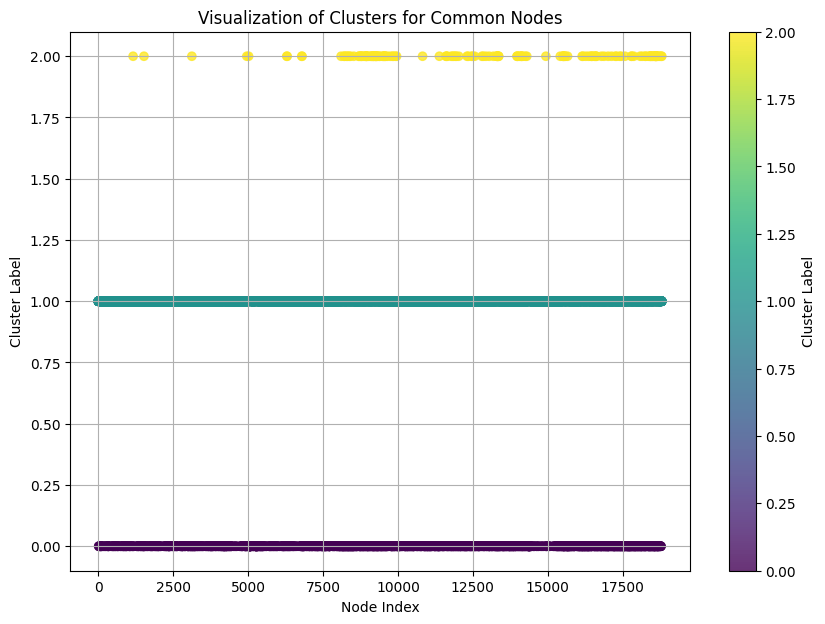

In [16]:
# Step 1: Load Graph and Hypergraph
def load_network_data(filename, max_edges=1100000):
    G = nx.Graph()
    hyperedges = defaultdict(list)

    with open(filename, 'r') as file:
        for i, line in enumerate(file):
            if i >= max_edges:
                break
            if not line.startswith('#'):
                nodes = list(map(int, line.strip().split()))
                u, v = nodes[0], nodes[1:]
                G.add_edges_from([(u, vi) for vi in v])
                hyperedges[u] = v

    H = hnx.Hypergraph(hyperedges)
    return G, H


# Step 2: Graph Community Detection (Louvain)
def graph_community_detection(G):
    return community_louvain.best_partition(G)


# Step 3: Hypergraph Community Detection (Spectral Clustering)
def build_incidence_matrix(H):
    nodes = list(H.nodes)
    edges = list(H.edges)
    node_index = {node: i for i, node in enumerate(nodes)}
    edge_index = {edge: i for i, edge in enumerate(edges)}

    incidence_data = []
    row_indices = []
    col_indices = []

    for edge_id, nodes in H.incidence_dict.items():
        for node in nodes:
            if node in node_index:
                row_indices.append(node_index[node])
                col_indices.append(edge_index[edge_id])
                incidence_data.append(1)

    incidence_matrix = csr_matrix((incidence_data, (row_indices, col_indices)), shape=(len(H.nodes), len(H.edges)))
    return incidence_matrix


def hypergraph_community_detection(H, num_clusters=5, clustering_method="spectral"):
    nodes = list(H.nodes)
    incidence_matrix = build_incidence_matrix(H)
    adjacency = incidence_matrix @ incidence_matrix.T

    if clustering_method == "spectral":
        clustering = SpectralClustering(n_clusters=num_clusters, affinity="precomputed", random_state=42)
    else:
        raise ValueError(f"Clustering method '{clustering_method}' is not supported.")

    labels = clustering.fit_predict(adjacency.toarray())
    return {node: labels[i] for i, node in enumerate(nodes)}


# Step 4: Extract Communities
def extract_communities(partition):
    communities = defaultdict(set)
    for node, community in partition.items():
        communities[community].add(node)
    return communities


# Step 5: Find Common Nodes
def find_common_nodes(graph_partition, hypergraph_partition):
    common_nodes = {}
    for node, graph_comm in graph_partition.items():
        if node in hypergraph_partition:
            common_nodes[node] = (graph_comm, hypergraph_partition[node])
    return common_nodes


# Step 6: Cluster Common Nodes
def cluster_common_nodes(common_nodes, num_clusters=3):
    if len(common_nodes) < num_clusters:
        print(f"Not enough nodes to form {num_clusters} clusters. Using {len(common_nodes)} clusters instead.")
        num_clusters = len(common_nodes)

    common_node_ids = list(common_nodes.keys())
    common_labels = np.array([val[0] for val in common_nodes.values()]).reshape(-1, 1)
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    clustered_labels = kmeans.fit_predict(common_labels)
    return common_node_ids, clustered_labels


# Step 7: Evaluate Clustering Metrics
def evaluate_clustering_metrics(true_labels, pred_labels):
    nmi = normalized_mutual_info_score(true_labels, pred_labels)
    ari = adjusted_rand_score(true_labels, pred_labels)
    jaccard = jaccard_score(true_labels, pred_labels, average='macro', zero_division=0)
    f1 = f1_score(true_labels, pred_labels, average='macro', zero_division=0)
    precision = precision_score(true_labels, pred_labels, average='macro', zero_division=0)
    recall = recall_score(true_labels, pred_labels, average='macro', zero_division=0)
    homogeneity = homogeneity_score(true_labels, pred_labels)
    completeness = completeness_score(true_labels, pred_labels)
    v_measure = v_measure_score(true_labels, pred_labels)

    # Calculate Purity
    contingency = contingency_matrix(true_labels, pred_labels)
    purity = np.sum(np.amax(contingency, axis=0)) / np.sum(contingency)

    print(f"NMI: {nmi:.4f}")
    print(f"ARI: {ari:.4f}")
    print(f"Jaccard Similarity Index: {jaccard:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Purity: {purity:.4f}")
    print(f"Homogeneity: {homogeneity:.4f}")
    print(f"Completeness: {completeness:.4f}")
    print(f"V-measure: {v_measure:.4f}")


# Step 8: Visualize Clusters
def visualize_clusters(node_ids, labels):
    labels = np.array(labels)
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(range(len(labels)), labels, c=labels, cmap='viridis', alpha=0.8)
    plt.title("Visualization of Clusters for Common Nodes")
    plt.xlabel("Node Index")
    plt.ylabel("Cluster Label")
    plt.colorbar(scatter, label="Cluster Label")
    plt.grid(True)
    plt.show()


# Function to print all communities
def print_all_communities(communities, label="Community"):
    print(f"Total {label}s: {len(communities)}")
    for community_id, nodes in communities.items():
        print(f"{label} {community_id} (Size: {len(nodes)})")
    print()


# Function to compare all communities in detail
def compare_all_communities(graph_comm, hypergraph_comm):
    print("Detailed Comparison of Graph and Hypergraph Communities:")
    total_matches = 0
    for graph_id, graph_nodes in graph_comm.items():
        match_found = False
        for hyper_id, hyper_nodes in hypergraph_comm.items():
            overlap = len(graph_nodes & hyper_nodes)
            if overlap > 0:
                match_found = True
                print(
                    f"Graph Community {graph_id} (Size: {len(graph_nodes)}) overlaps with "
                    f"Hypergraph Community {hyper_id} (Size: {len(hyper_nodes)}): "
                    f"{overlap} shared nodes."
                )
        if not match_found:
            print(f"Graph Community {graph_id} (Size: {len(graph_nodes)}) has no overlap with any Hypergraph Community.")
        total_matches += 1 if match_found else 0
    print(f"\nTotal Matched Communities: {total_matches}/{len(graph_comm)}\n")


# Main Function
def main():
    filename = '/kaggle/input/cse551/Undirected_Youtube_network.txt'

    # Step 1: Load Network Data
    G, H = load_network_data(filename)
    print(f"Graph loaded with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    print(f"Hypergraph loaded with {len(H.edges)} hyperedges.")

    # Step 2: Graph Community Detection
    graph_partition = graph_community_detection(G)
    graph_comm = extract_communities(graph_partition)
    print_all_communities(graph_comm, label="Graph Community")

    # Step 3: Hypergraph Community Detection
    hypergraph_partition = hypergraph_community_detection(H, num_clusters=5)
    hypergraph_comm = extract_communities(hypergraph_partition)
    print_all_communities(hypergraph_comm, label="Hypergraph Community")

    # Step 4: Compare Communities
    compare_all_communities(graph_comm, hypergraph_comm)

    # Step 5: Find Common Nodes
    common_nodes = find_common_nodes(graph_partition, hypergraph_partition)
    print(f"Number of common nodes: {len(common_nodes)}")

    # Step 6: Cluster Common Nodes
    if len(common_nodes) > 0:
        common_node_ids, cluster_labels = cluster_common_nodes(common_nodes, num_clusters=3)

        # Step 7: Evaluate Clustering
        true_labels = [val[1] for val in common_nodes.values()]
        evaluate_clustering_metrics(true_labels, cluster_labels)

        # Step 8: Visualize Clusters
        visualize_clusters(common_node_ids, cluster_labels)
    else:
        print("No common nodes to cluster and visualize.")


if __name__ == "__main__":
    main()
